In [9]:
from math import factorial
import numpy as np

## SIR model with delay
def SIR(beta, gamma):
    def SIR_dde(t, y1, y2):
        S, I, R = y1
        S_d, I_d, R_d = y2
        return np.array([-beta*S*I_d, beta*S*I_d - gamma*I, gamma*I])
    return SIR_dde



## History function
def phi_SIR(t):
    return np.array([0.8, 0.2, 0])  


#Interpolation con Newton (hacia atrás)
def y_delayed_newton_backward(t, y, t_q, number_pts, phi):

    h = t[1] - t[0]
    pts = number_pts
    j = np.searchsorted(t, t_q) - 1
    shift = int(np.floor(pts / 2))

    idx = np.arange(j - pts + shift + 1, j + shift + 1)
    if idx[0] >= 0:
        t_sub = t[idx]
        y_sub = y[idx]
    else:
        idx1 = idx[idx < 0]
        idx2 = idx[idx >= 0]
        t1 = t[0] + h * idx1
        y1 = np.array([phi(ti) for ti in t1])
        t2 = t[idx2]
        y2 = y[idx2]
        
        t_sub = np.hstack((t1, t2))
        y_sub = np.hstack((y1, y2))

    coef = np.array(y_sub, dtype=float)

    for k in range(1, pts):
        for i in range(pts - 1 , k - 1, -1):
            coef[i] = (coef[i] - coef[i-1]) / (t_sub[i] - t_sub[i-k])

    p = coef[pts-1]
    for k in range(pts-2, -1, -1):
        p = coef[k] + (t_q - t_sub[k]) * p

    return p

In [11]:
def RK4sys_newton_dde(f, phi, t_0, t_f, tau, N, history=False,pts=3):

    ## Preliminaries
    h = (t_f - t_0) / N
    t = np.linspace(t_0, t_f, N+1)
    y0 = phi(t_0)
    y = np.zeros((len(t), len(y0)))
    y[0] = y0

    ## EE with linear interpolation for delay term
    for i in range(0, N):
        if t[i] <= tau:
            k1 = f(t[i], y[i], phi(t[i] - tau))
            k2 = f(t[i] + 0.5*h, y[i] + h*0.5*k1, phi(t[i] + 0.5*h - tau))
            k3 = f(t[i] + 0.5*h, y[i] + h*0.5*k2, phi(t[i] + 0.5*h - tau))
            k4 = f(t[i] + h, y[i] + h*k3, phi(t[i] + h - tau))
            y[i+1] = y[i] + h*(k1/6 + k2/3 + k3/3 + k4/6)
        else:
            k1 = f(t[i], y[i], y_delayed_newton_backward(t, y, t[i] - tau,pts,phi))
            k2 = f(t[i] + 0.5*h, y[i] + h*0.5*k1, y_delayed_newton_backward(t, y, t[i] + 0.5*h - tau,pts,phi))
            k3 = f(t[i] + 0.5*h, y[i] + h*0.5*k2, y_delayed_newton_backward(t, y, t[i] + 0.5*h - tau,pts,phi))
            k4 = f(t[i] + h, y[i] + h*k3, y_delayed_newton_backward(t, y, t[i] + h - tau,pts,phi))
            y[i+1] = y[i] + h*(k1/6 + k2/3 + k3/3 + k4/6)

    if history == True: ## Wether the solution should include the history (values on the interval [t_0 - tau, t_0])
        t_hist = np.linspace(t_0-tau, t_0, int(N / (t_f // tau) + 1))
        y_hist = np.array([phi(ti) for ti in t_hist])
        t = np.concatenate((t_hist, t))
        y = np.concatenate((y_hist, y))

    return h, t, y

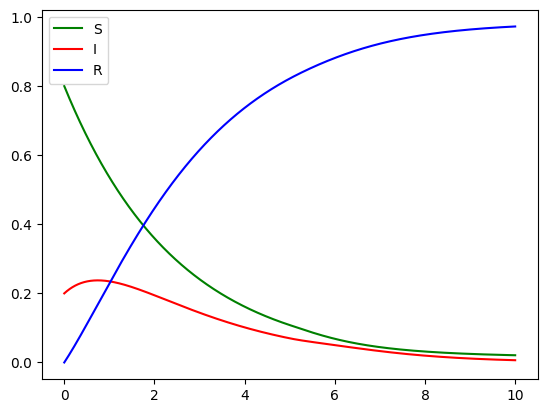

In [12]:
beta = 2
gamma = 1
t_0 = 0
t_f = 10
tau = 5
N = 10**4

h, t, y_rk4 = RK4sys_newton_dde(SIR(beta, gamma), phi_SIR, t_0, t_f, tau, N, False)

S_sol = y_rk4[:,0]
I_sol = y_rk4[:,1]
R_sol = y_rk4[:,2]

import matplotlib.pyplot as plt
plt.plot(t, S_sol, color='green', label='S')
plt.plot(t, I_sol, color='red', label='I')
plt.plot(t, R_sol, color='blue', label='R')
plt.legend()